In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Single-end Read Trimming and QC for Random Oligos

### Trimming

In [2]:
def fastq_to_filtered_fasta(input_fastq):
    """
    Processes the first 10 examples in the FASTQ file and prints trimmed sequences that match the expected oligo structure:
    Non-binding sequence (NBS) - TGTTTAC - TCGA - NNNNNNN - NBS.
    
    Requirements for a valid trimmed sequence:
    - It starts with the TGTTTAC FKHM (7 bp)
    - We check the first TCGA spacer after the upstream sequence and FKHM
    - Sequence must be 18 bp total (TGTTTAC + TCGA + 7bp variable region)
    - The 5bp flanking NBS motifs (AAATT upstream, AATTC downstream) must be present
    - No ambiguous 'N' bases allowed in the variable region
    """

    sequence_counter = 0
    print(f"Processing {input_fastq}")

    with open(input_fastq, "rt") as infile:
        for record in SeqIO.parse(infile, "fastq"):
            sequence = str(record.seq)
            sequence_counter += 1
            quality_scores = record.letter_annotations["phred_quality"]
            print(f"Full sequence #{sequence_counter}: {sequence}")
            
            # Find the TCGA motif after the expected upstream region (~27nt upstream + 7nt NNNNNNN)
            # Skip any TCGA occurrences too early in the sequence
            tcga_index = sequence.find("TCGA")
            while tcga_index != -1 and tcga_index < 35:
                tcga_index = sequence.find("TCGA", tcga_index + 1)


            if tcga_index != -1:
                # Look for the upstream 5bp non-binding motif ("AAATT") ending just before the first 7 Ns 
                start_index = sequence.rfind("AAATT", 0, tcga_index - 7)
                if start_index != -1:
                    start_index += 5  # Move to the position immediately after "AAATT"

                # Look for the downstream 5bp non-binding motif ("AATTC") that follows the variable region
                end_index = sequence.find("AATTC", tcga_index + 11)

                # Proceed only if both flanking motifs are found and in the correct order
                if start_index != -1 and end_index != -1 and start_index < end_index:
                    trimmed_seq = sequence[start_index:end_index]

                    # Ensure the trimmed sequence is exactly 18bp
                    # Also check that the variable regions do not contain an 'N'
                    if len(trimmed_seq) == 18 and 'N' not in trimmed_seq:
                        quality_subscores = quality_scores[start_index:end_index]
                        high_quality_count = sum(1 for q in quality_subscores if q >= 20)
                        if high_quality_count == 18:
                            print(f"Trimmed sequence #{sequence_counter}: {trimmed_seq}")
                        else:
                            print(f'Bad quality sequence')
                    else:
                        print(f'Incorrect sequence length')
                else:
                    print(f'Incorrect non-binding sequence')
            else:
                print(f'No TCGA spacer found')

        print('')

# Run on example FASTQ files (first 5 reads each, because full file would be too large)
fastq_to_filtered_fasta("figure2_files/foxp1_first5.fastq")
fastq_to_filtered_fasta("figure2_files/foxp3_first5.fastq")

Processing figure2_files/foxp1_first5.fastq
Full sequence #1: GNAGATGGCGCTTGAACAGAAAGATTAGGAAAATTTCCACAGTCGACGCGTTGAATTCATCAGCTGGGAGAACAATCATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACACTCGCTAATCTGGGG
Trimmed sequence #1: TCCACAGTCGACGCGTTG
Full sequence #2: GNAGATGGCGCTTGAACAGAAAGATTAGGAAAATTGCACAAATCGAAACAGGAAATTCATCAGCTGGGAGAACAATCATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACACTCGCTAATCTGGGG
Trimmed sequence #2: GCACAAATCGAAACAGGA
Full sequence #3: GNAGATGGCGCTTGAACAGAAAGATTAGGAAAATTTGTACATTCGAGTACAGGAATTCATCAGCTGGGAGAACAATCATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACACTCGCTAATCTGGGG
Trimmed sequence #3: TGTACATTCGAGTACAGG
Full sequence #4: GNAGATGGCGCTTGAACAGAAAGATTAGGAAAATTGGGATGCTCGAGCTAGTAAATTCATCAGCTGGGAGAACAATCATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACACTCGCTAATCTGGGG
Trimmed sequence #4: GGGATGCTCGAGCTAGTA
Full sequence #5: GNAGATGGCGCTTGAACAGAAAGATTAGGAAAATTGATTCATTCGAAGTCAGTAATTCATCAGCTGGGAGAACAATCATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACACTCGCTAATCTGGGG
Trimmed sequence #5: GATTCATTCGAAGTCAGT

Processing

### Relationship between FoxP3 and FoxP1 PD-seq sequences

In [3]:
# Load the top 1% file
df_top_1_percent = pd.read_pickle("figure2_files/top_1_percent_ranked_by_foxp3.pkl")

In [4]:
df_top_1_percent.head()

,Sequence,Counts_RPM_Foxp3,Counts_RPM_Foxp1
0,TGTTTACTCGAGTAAACA,2.894954,0.106186
1,GCGTGCATCGAGGCACGC,2.249490,0.075847
2,GCGTGCCTCGATGCACGC,1.955659,0.080904
3,GCGTGCATCGACGCACGC,1.724448,0.106186
4,GCGCGCATCGATGCACGC,1.709998,0.060678


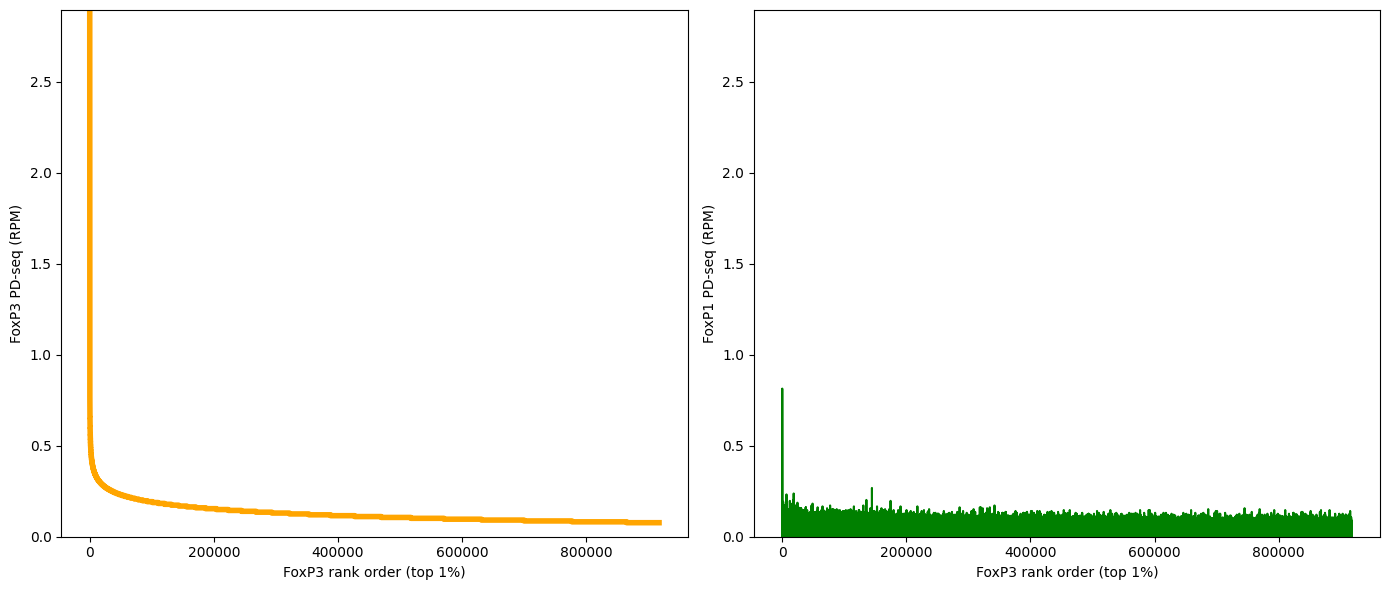

In [5]:
# Recompute axis limits to match scales across both Foxp3 and Foxp1 plots
max_counts_rpm = max(df_top_1_percent['Counts_RPM_Foxp3'].max(), df_top_1_percent['Counts_RPM_Foxp1'].max())
min_counts_rpm = min(df_top_1_percent['Counts_RPM_Foxp3'].min(), df_top_1_percent['Counts_RPM_Foxp1'].min())

# Plot setup
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# FoxP3 Plot (Left)
axs[0].plot(
    df_top_1_percent['Counts_RPM_Foxp3'].values,
    label='Foxp3 Counts (RPM)',
    color='orange',
    linewidth=4
)
axs[0].set_xlabel('FoxP3 rank order (top 1%)')
axs[0].set_ylabel('FoxP3 PD-seq (RPM)')
axs[0].set_ylim(min_counts_rpm, max_counts_rpm)

# FoxP1 Plot (Right)
axs[1].plot(
    df_top_1_percent['Counts_RPM_Foxp1'].values,
    label='Foxp1 Counts (RPM)',
    color='green'
)
axs[1].set_xlabel('FoxP3 rank order (top 1%)')
axs[1].set_ylabel('FoxP1 PD-seq (RPM)')
axs[1].set_ylim(min_counts_rpm, max_counts_rpm)

# Save and show
plt.tight_layout()
plt.show()

# Unshifted Heatmap

In [6]:
# Handle logistics of plotting heatmaps

def process_matrices(
    data_dict,
    total_reads=None,
    probability_matrix=None,
    rescale=True,
    rescale_only=False,
    rescale_range=(0, 100)
):
    """
    Normalizes and/or rescales motif count matrices for heatmap visualization.

    Parameters:
        data_dict (dict): Dictionary of matrices (as NumPy arrays or DataFrames).
        total_reads (int, optional): Total read count for RPM normalization.
        probability_matrix (dict, optional): Dictionary of expected probability matrices to normalize against.
        rescale (bool): If True, apply global min-max scaling across all matrices.
        rescale_only (bool): If True, skip normalization and only apply min-max scaling.
        rescale_range (tuple): Range to scale values to (default: 0–100).

    Returns:
        dict: Dictionary of processed matrices with same keys as input.
    """
    processed = {}

    # Helper to ensure everything is NumPy arrays
    def to_array(matrix):
        return matrix.values if isinstance(matrix, pd.DataFrame) else matrix

    # If just rescaling existing matrices without normalization
    if rescale_only:
        all_values = np.concatenate([to_array(m).flatten() for m in data_dict.values()])
        global_min, global_max = all_values.min(), all_values.max()
        for key, matrix in data_dict.items():
            matrix = to_array(matrix)
            scaled = (matrix - global_min) / (global_max - global_min) * (rescale_range[1] - rescale_range[0])
            processed[key] = scaled
        return processed

    # Normalize each matrix (optionally using a probability matrix first)
    for key, matrix in data_dict.items():
        matrix = to_array(matrix)

        if probability_matrix:
            expected = to_array(probability_matrix[key])
            matrix = np.nan_to_num(matrix / expected)

        if total_reads:
            matrix = (matrix / total_reads) * 1e6  # Convert to RPM

        processed[key] = matrix

    # Global min-max rescaling after normalization
    if rescale:
        all_values = np.concatenate([m.flatten() for m in processed.values()])
        global_min, global_max = all_values.min(), all_values.max()
        for key in processed:
            matrix = processed[key]
            processed[key] = (matrix - global_min) / (global_max - global_min) * (rescale_range[1] - rescale_range[0])

    return processed


def plot_orientation_heatmaps(
    data_dict,
    title_prefix,
    x_labels,
    y_labels,
    cmap="Blues",
    colorbar_label=None,
    save_file=None
):
    """
    Plots a 2x2 grid of orientation-based motif pair heatmaps.

    Parameters:
        data_dict (dict): Dictionary with four orientations as keys and matrices as values.
        title_prefix (str): Title shown above the figure.
        x_labels (list): List of 10 motif labels for the x-axis.
        y_labels (list): List of 10 motif labels for the y-axis.
        cmap (str): Matplotlib colormap (default: "Blues").
        colorbar_label (str, optional): Label for the colorbar.
        save_file (str, optional): If provided, save figure to this path.
    """
    vmin, vmax = 0, 100
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.03, wspace=0.03)

    layout = [
        ("Tail-to-Head", 0, 0),
        ("Tail-to-Tail", 0, 1),
        ("Head-to-Head", 1, 0),
        ("Head-to-Tail", 1, 1)
    ]

    heatmaps_list = []

    for name, row, col in layout:
        ax = axes[row][col]
        matrix = data_dict[name]

        # Main heatmap
        im = ax.imshow(matrix, cmap=cmap, aspect="equal", vmin=vmin, vmax=vmax)

        # Add visual markers (white grid + red/green highlight boxes)
        ax.axhline(y=3.5, color='white', linewidth=5)
        ax.axvline(x=3.5, color='white', linewidth=5)
        ax.add_patch(patches.Rectangle((-0.5, -0.5), 4, 4, edgecolor='red', linewidth=5, facecolor='none'))
        ax.add_patch(patches.Rectangle((-10.5, 3.5), 10, 6, edgecolor='green', linewidth=5, facecolor='none'))
        ax.add_patch(patches.Rectangle((3.5, -1.5), 6, 1, edgecolor='green', linewidth=5, facecolor='none'))

        # Y-axis tick labels
        if col == 0:
            ax.set_yticks(range(len(matrix)))
            ax.set_yticklabels(y_labels, fontsize=10)
            for tick in ax.get_yticklabels()[:4]: tick.set_color('red')
            for tick in ax.get_yticklabels()[4:10]: tick.set_color('green')
        else:
            ax.set_yticks([])
            ax.set_yticklabels([])

        # X-axis tick labels
        if row == 1:
            ax.set_xticks([])
            ax.set_xticklabels([])
        else:
            ax.xaxis.set_label_position('top')
            ax.xaxis.tick_top()
            ax.set_xticks(range(len(matrix)))
            ax.set_xticklabels(x_labels, rotation=45, ha="left", fontsize=10)
            for tick in ax.get_xticklabels()[:4]: tick.set_color('red')
            for tick in ax.get_xticklabels()[4:10]: tick.set_color('green')

        # Subplot label
        ax.text(0.5, -0.05, name, fontsize=12, ha='center', transform=ax.transAxes)
        heatmaps_list.append(im)

    # Add a single shared colorbar
    label = colorbar_label or f"{title_prefix} RPM (scaled)"
    fig.colorbar(heatmaps_list[0], ax=axes, location='right', fraction=0.02, pad=0.02, aspect=50, label=label)

    plt.suptitle(title_prefix, fontsize=16, y=1.01)
    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

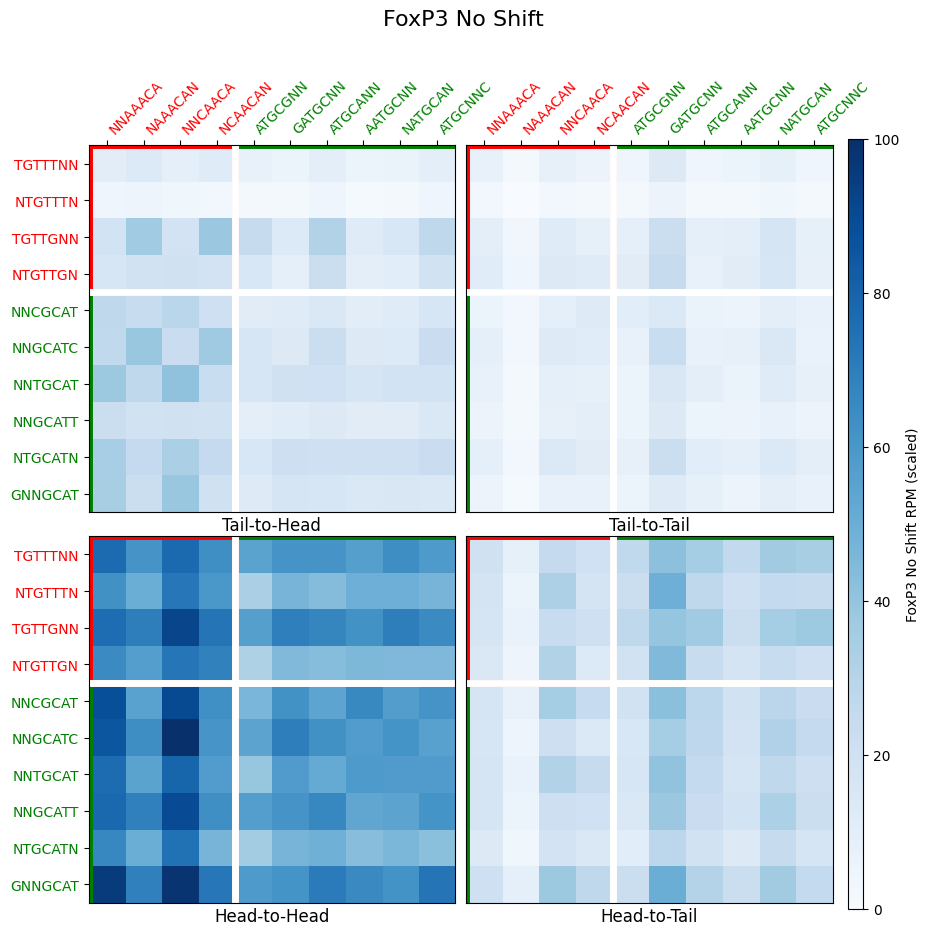

In [7]:
# Load unshifted FoxP3 motif pair count matrix
fp3_unshifted_counts = pd.read_pickle("figure2_files/fp3_heatmap_noshift.pkl")

# Total mapped reads for FoxP3 (used for RPM normalization)
foxp3_total_reads = 207_602_631

# Define forward and reverse-complement motif sets
forward_motifs = ['NNAAACA', 'NAAACAN', 'NNCAACA', 'NCAACAN', 'ATGCGNN', 'GATGCNN', 'ATGCANN', 'AATGCNN', 'NATGCAN', 'ATGCNNC']
reverse_motifs = ['TGTTTNN', 'NTGTTTN', 'TGTTGNN', 'NTGTTGN', 'NNCGCAT', 'NNGCATC', 'NNTGCAT', 'NNGCATT', 'NTGCATN', 'GNNGCAT']

# Normalize counts by total reads and scale each matrix to 0–100
processed_fp3 = process_matrices(fp3_unshifted_counts, total_reads=foxp3_total_reads)

# Visualize the normalized and scaled heatmaps
plot_orientation_heatmaps(
    processed_fp3,
    title_prefix="FoxP3 No Shift",
    x_labels=forward_motifs,
    y_labels=reverse_motifs
)

# Enrichment Normalization Using Structural Probabilities

### Generating Probability Matrix

In [8]:
def score_shift_rules(pair):
    """
    Assigns scores to motif pairs based on potential shifted alignment rules.
    Lower scores represent better motif overlap patterns under biological assumptions.
    """
    f1, f2 = pair
    scores = []

    # Right shift by 1
    if f1[0] in ['T', 'N'] and f2[0] in ['A', 'N']:
        scores.append(10 - int(f1[0] == 'T') - int(f2[0] == 'A'))

    # Right shift by 2
    if all([
        f1[0] in ['T', 'N'], f1[1] in ['T', 'N'],
        f2[0] in ['G', 'N'], f2[1] in ['A', 'N']
    ]):
        scores.append(10 - int(f1[0] == 'T') - int(f1[1] == 'T') - int(f2[0] == 'G') - int(f2[1] == 'A'))

    # Left shift by 1
    if f1[6] in ['T', 'N'] and f2[6] in ['A', 'N']:
        scores.append(10 - int(f1[6] == 'T') - int(f2[6] == 'A'))

    # Left shift by 2
    if all([
        f1[5] in ['T', 'N'], f1[6] in ['C', 'N'],
        f2[5] in ['A', 'N'], f2[6] in ['A', 'N']
    ]):
        scores.append(10 - int(f1[5] == 'T') - int(f1[6] == 'C') - int(f2[5] == 'A') - int(f2[6] == 'A'))

    return scores

def generate_probability_matrix(combo_list):
    """
    Builds a 10x10 probability matrix from motif combinations by scoring shifted alignments.
    Each cell is scaled for visualization based on the number of favorable shifts.
    """
    matrix = np.zeros((10, 10))
    for i, (motif1, motif2) in enumerate(combo_list):
        row, col = divmod(i, 10)
        scores = score_shift_rules((motif1, motif2))

        # Start with a baseline probability for exact match (4^-10)
        prob = 4 ** -10

        # Add probabilities for each favorable shift
        for score in scores:
            prob += 4 ** -score

        matrix[row, col] = prob * 1e5  # Scaled for interpretability

    matrix[matrix == 0] = np.nan
    return matrix


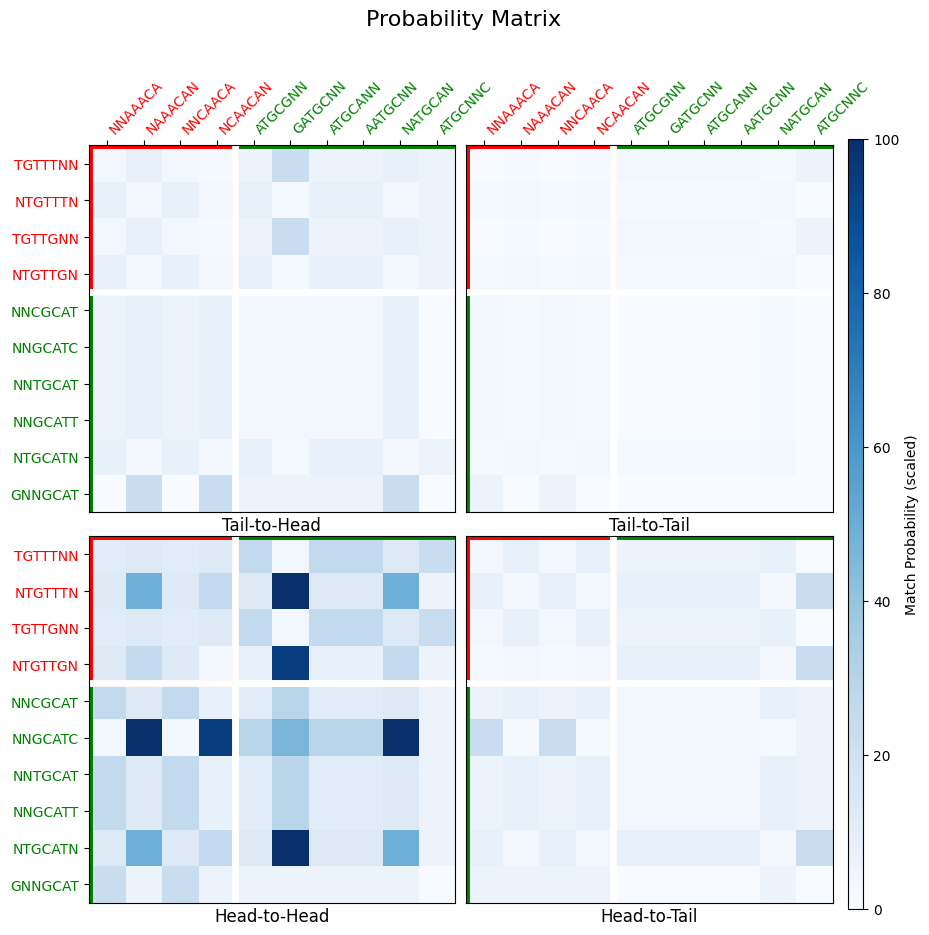

In [9]:
# Define forward and reverse-complement motif sets
forward_motifs = ['NNAAACA', 'NAAACAN', 'NNCAACA', 'NCAACAN', 'ATGCGNN', 'GATGCNN', 'ATGCANN', 'AATGCNN', 'NATGCAN', 'ATGCNNC']
reverse_motifs = ['TGTTTNN', 'NTGTTTN', 'TGTTGNN', 'NTGTTGN', 'NNCGCAT', 'NNGCATC', 'NNTGCAT', 'NNGCATT', 'NTGCATN', 'GNNGCAT']

# Define motif pair combinations for each orientation
# TH = Tail-to-Head, TT = Tail-to-Tail, HH = Head-to-Head, HT = Head-to-Tail
motif_combinations = {
    "TH": [(f1, f2) for f1 in forward_motifs for f2 in forward_motifs],  # FF
    "TT": [(f1, f2) for f1 in forward_motifs for f2 in reverse_motifs],  # FR
    "HH": [(f1, f2) for f1 in reverse_motifs for f2 in forward_motifs],  # RF
    "HT": [(f1, f2) for f1 in reverse_motifs for f2 in reverse_motifs],  # RR
}

# Generate the probability matrices for each orientation
prob_matrix_TH = generate_probability_matrix(motif_combinations["TH"])  # FF
prob_matrix_TT = generate_probability_matrix(motif_combinations["TT"])  # FR
prob_matrix_HH = generate_probability_matrix(motif_combinations["HH"])  # RF
prob_matrix_HT = generate_probability_matrix(motif_combinations["HT"])  # RR

# Rescale all matrices together (0–100) for consistent color range
probability_matrices_scaled = process_matrices({
    "Tail-to-Head": prob_matrix_TH,
    "Tail-to-Tail": prob_matrix_TT,
    "Head-to-Head": prob_matrix_HH,
    "Head-to-Tail": prob_matrix_HT
}, rescale_only=True)

# Plot probability matrices as a heatmap
plot_orientation_heatmaps(
    probability_matrices_scaled,
    title_prefix="Probability Matrix",
    x_labels=forward_motifs,
    y_labels=reverse_motifs,
    colorbar_label="Match Probability (scaled)"
)

### Shifted Heatmaps

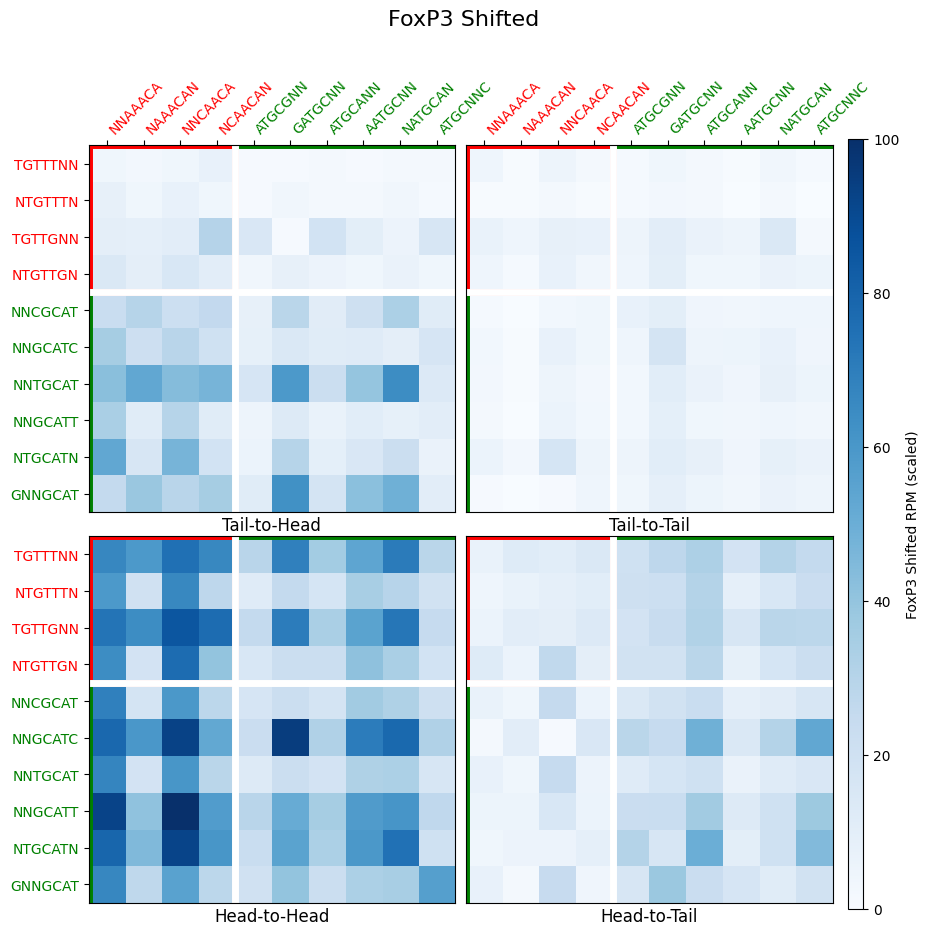

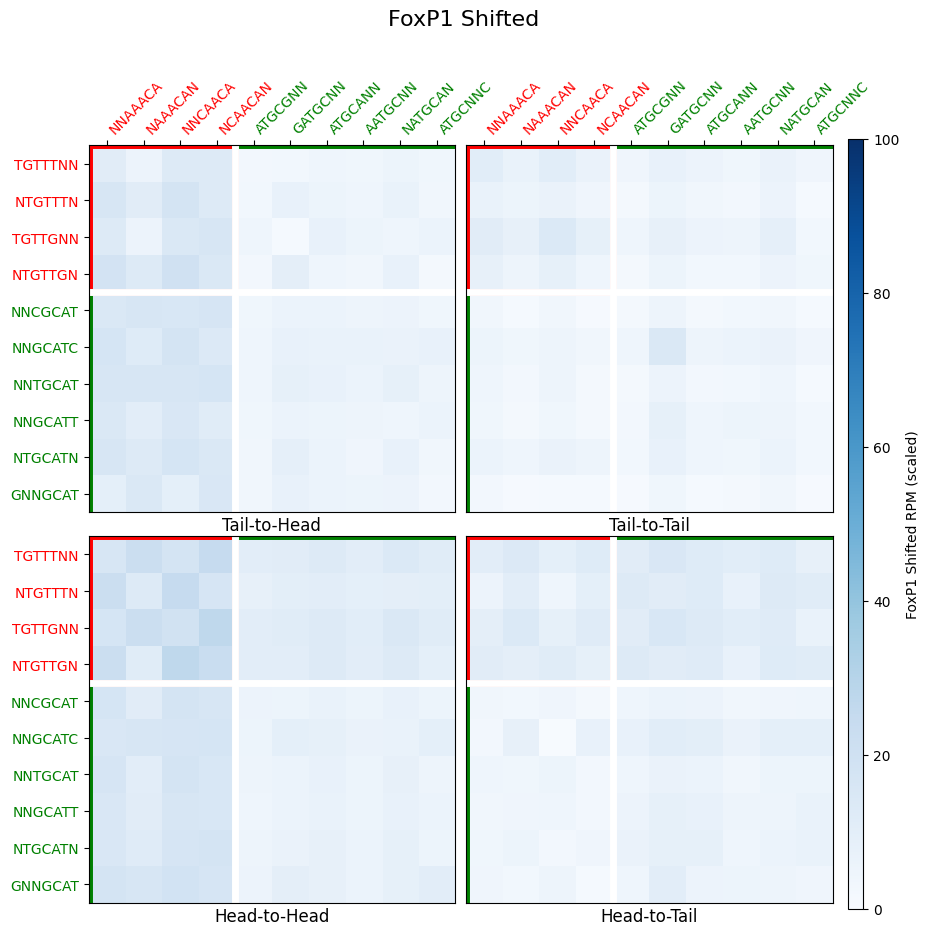

In [10]:
# Load shifted FoxP3 and FoxP1 motif pair count matrices
fp3_and_fp1_shifted_counts = pd.read_pickle("figure2_files/heatmaps_shifted_fp3_fp1.pkl")

# Total mapped reads for RPM normalization
total_reads_fp3 = 207_602_631
total_reads_fp1 = 197_765_463

# Motif labels for plot axes
motifs_forward = ['NNAAACA', 'NAAACAN', 'NNCAACA', 'NCAACAN', 'ATGCGNN', 'GATGCNN', 'ATGCANN', 'AATGCNN', 'NATGCAN', 'ATGCNNC']
motifs_reverse = ['TGTTTNN', 'NTGTTTN', 'TGTTGNN', 'NTGTTGN', 'NNCGCAT', 'NNGCATC', 'NNTGCAT', 'NNGCATT', 'NTGCATN', 'GNNGCAT']

# Map orientation labels to their corresponding probability matrices
prob_map = {
    "Head-to-Head": prob_matrix_HH,
    "Head-to-Tail": prob_matrix_HT,
    "Tail-to-Head": prob_matrix_TH,
    "Tail-to-Tail": prob_matrix_TT
}

# Step 1 — Normalize both FP3 and FP1 heatmaps using their respective read totals and probability matrices
# Skip rescaling for now (we'll apply a shared 0–100 scale after combining)
fp3_normalized = process_matrices(
    data_dict=fp3_and_fp1_shifted_counts["FP3"],
    total_reads=total_reads_fp3,
    probability_matrix=prob_map,
    rescale=False
)

fp1_normalized = process_matrices(
    data_dict=fp3_and_fp1_shifted_counts["FP1"],
    total_reads=total_reads_fp1,
    probability_matrix=prob_map,
    rescale=False
)

# Step 2 — Combine all values to compute global min and max for consistent scaling
all_normalized_matrices = {("FP3", k): v for k, v in fp3_normalized.items()}
all_normalized_matrices.update({("FP1", k): v for k, v in fp1_normalized.items()})

all_values = np.concatenate([matrix.flatten() for matrix in all_normalized_matrices.values()])
global_min = all_values.min()
global_max = all_values.max()

# Step 3 — Apply global min-max scaling (0–100) to both FP3 and FP1 matrices
def rescale_matrices(data_dict, min_val, max_val):
    return {
        k: (m - min_val) / (max_val - min_val) * 100
        for k, m in data_dict.items()
    }

fp3_scaled = rescale_matrices(fp3_normalized, global_min, global_max)
fp1_scaled = rescale_matrices(fp1_normalized, global_min, global_max)

# Step 4 — Plot heatmaps with consistent color scale for both datasets
plot_orientation_heatmaps(fp3_scaled, "FoxP3 Shifted", motifs_forward, motifs_reverse)
plot_orientation_heatmaps(fp1_scaled, "FoxP1 Shifted", motifs_forward, motifs_reverse)

### Bar Graphs

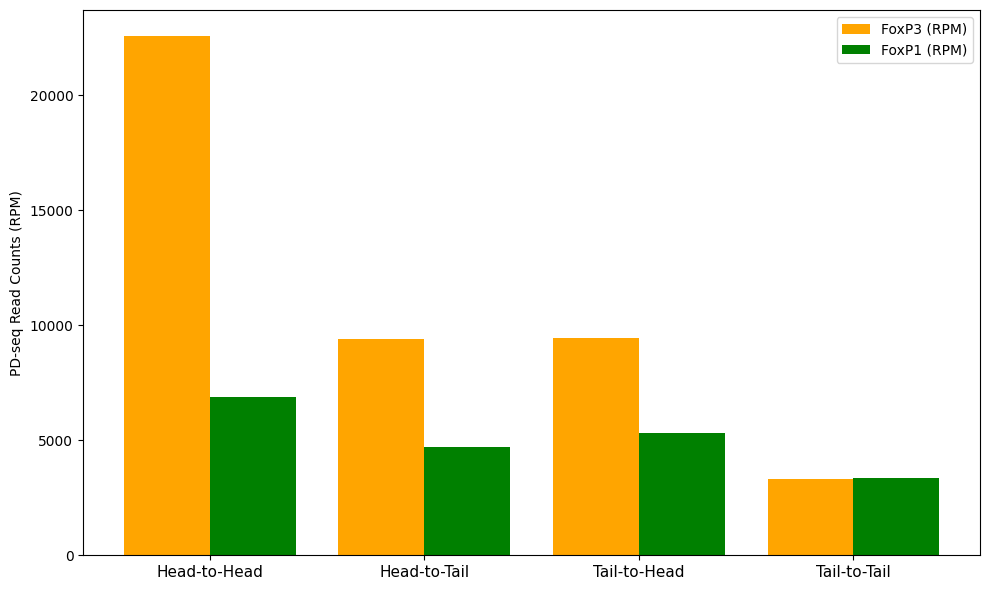

In [11]:
# Load precomputed shifted FoxP3 and FoxP1 heatmaps
shifted_counts = pd.read_pickle("figure2_files/heatmaps_shifted_fp3_fp1.pkl")

# Access each orientation's matrix
heatmap_fp3 = shifted_counts["FP3"]
heatmap_fp1 = shifted_counts["FP1"]


# Normalize by motif-pair background probabilities, replacing NaNs with 0
fp3_hh = np.nan_to_num(heatmap_fp3["Head-to-Head"] / prob_matrix_HH)
fp3_ht = np.nan_to_num(heatmap_fp3["Head-to-Tail"] / prob_matrix_HT)
fp3_th = np.nan_to_num(heatmap_fp3["Tail-to-Head"] / prob_matrix_TH)
fp3_tt = np.nan_to_num(heatmap_fp3["Tail-to-Tail"] / prob_matrix_TT)

fp1_hh = np.nan_to_num(heatmap_fp1["Head-to-Head"] / prob_matrix_HH)
fp1_ht = np.nan_to_num(heatmap_fp1["Head-to-Tail"] / prob_matrix_HT)
fp1_th = np.nan_to_num(heatmap_fp1["Tail-to-Head"] / prob_matrix_TH)
fp1_tt = np.nan_to_num(heatmap_fp1["Tail-to-Tail"] / prob_matrix_TT)


# Total mapped reads for each dataset (used for RPM normalization)
total_reads_fp3 = 207_602_631
total_reads_fp1 = 197_765_463

# Convert total counts to RPM (Reads Per Million)
rpm_fp3 = [
    np.sum(fp3_hh) / total_reads_fp3 * 1e6,  # Head-to-Head
    np.sum(fp3_ht) / total_reads_fp3 * 1e6,  # Head-to-Tail
    np.sum(fp3_th) / total_reads_fp3 * 1e6,  # Tail-to-Head
    np.sum(fp3_tt) / total_reads_fp3 * 1e6   # Tail-to-Tail
]

rpm_fp1 = [
    np.sum(fp1_hh) / total_reads_fp1 * 1e6,  # Head-to-Head
    np.sum(fp1_ht) / total_reads_fp1 * 1e6,  # Head-to-Tail
    np.sum(fp1_th) / total_reads_fp1 * 1e6,  # Tail-to-Head
    np.sum(fp1_tt) / total_reads_fp1 * 1e6   # Tail-to-Tail
]

# Orientation labels for x-axis
orientations = ['Head-to-Head', 'Head-to-Tail', 'Tail-to-Head', 'Tail-to-Tail']
x = np.arange(len(orientations))
bar_width = 0.4

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width / 2, rpm_fp3, bar_width, label='FoxP3 (RPM)', color='orange')
plt.bar(x + bar_width / 2, rpm_fp1, bar_width, label='FoxP1 (RPM)', color='green')

plt.xticks(x, orientations, fontsize=11)
plt.ylabel('PD-seq Read Counts (RPM)')
plt.legend()
plt.tight_layout()
plt.show()